# Анализ картинок

Создайте эмбеддинги изображений и отобразите их в tensorboard projector'е

1. Скачайте датасет [CelebA](https://pytorch.org/vision/stable/datasets.html#celeba) или любой другой не рассмотренный на лекции
1. Выберите одну из предобученных [моделей torchvision](https://pytorch.org/vision/stable/models.html)
1. Создайте эмбеддинги изображений из датасета
1. Визуализируйте эмбеддинги в tensorboard projector

In [1]:
import random
import numpy as np

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from torchvision.models import resnet50

from tqdm.notebook import tqdm, trange 

# Фиксируем random seed для воспроизводимости результатов
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


OUTPUT_DIM = 10  # Количество классов
EPOCH_NUM = 2  # Сколько эпох будет обучать модель

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
basic_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])  # Базовые аугментации для тренировочных данных (грубо говоря бесплатное увеличение тренировочной выборки)

In [3]:
# Загрузим данные

train_dataset = STL10(
    root='./STL10/train',
    split='train', 
    transform=basic_transform,
    download=True)

test_dataset = torchvision.datasets.STL10(
    root='./STL10/test',
    split='test', 
    transform=transforms.ToTensor(),  # Для тестовых данные НЕ НАДО использовать нгикакие аугментации
    download= True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Создадим DataLoader'ы (для того чтобы было проще итерироваться)

dataloaders = {
    'train': DataLoader(
        dataset=train_dataset,
        batch_size=128, 
        shuffle=True
    ),
    'val': DataLoader(
        dataset=test_dataset,
        batch_size=128, 
        shuffle=False
    )
}

In [5]:
# Создадим класс нашей модели

# Так как мы хотим использовать все фишки библиотеки Pytorch важно наследоваться от nn.Module
class STL10Classifier(nn.Module):
    def __init__(self, ouput_dim): #ouput_dim - кол-во категорий
        super(STL10Classifier, self).__init__()  # "Регистрируем" создаваемый объект как нейросетевую модель
        self.model = resnet50(pretrained=True)  # Скачиваем пред-обученную основу для нашей модели
        
        # "Замораживаем" все веса для ускорения обучения (мы считаем что они уже хорошо обучены)
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Создаем "голову" которую мы и будем обучать
        self.fc1 = nn.Sequential(
            nn.Linear(1000, 64),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(64, ouput_dim)
        )
    
    def embed(self, x):
        return self.fc1(self.model(x))
    
    # Описываем как именно наша модель будет генерировать предсказания
    def forward(self, x):
        resnet_out = self.embed(x)
        return self.fc2(resnet_out)

In [6]:
model = STL10Classifier(OUTPUT_DIM)
model = model.to(DEVICE)  # Переносим модель на GPU

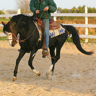

In [7]:
from PIL import Image
Image.fromarray(np.transpose(test_dataset.data[0], (1, 2, 0)))

In [8]:
test_dataset[0][0].size()

torch.Size([3, 96, 96])

In [9]:
import matplotlib.pyplot as plt
img = test_dataset[0][0].detach().numpy()
img = np.transpose(img, (1,2,0))
img.shape

(96, 96, 3)

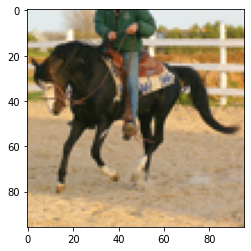

In [10]:
plt.imshow(img)

In [11]:
# Создаем функцию ошибки (так как задача многоклассовой классификации, то используем кросс-энтропию)
# Более подробно об этом будет в курсе машинного обучения
loss_function = torch.nn.CrossEntropyLoss()

# Регистрируем для нашей модели способ изменения её весов
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-4)

In [12]:
loss_hist = {'train': [], 'val': []}
acc_hist = {'train': [], 'val': []}

# Важно! В данном примере точность используется для упрощения.
# Никогда не используйте её если у вас несбалансированная выборка
# Возьмите лучше F_score или ROC_AUC (об этом вам потом расскажут)

# Основной алгоритм обучения
for epoch in trange(EPOCH_NUM, desc='Whole pipeline'):
    
    for phase in ['train', 'val']:
        dataloader = dataloaders[phase]
        
        # Это условие необходимо так как у нас есть слой DropOut
        # И на валидации его принято фиксировать
        if phase == 'train':
            model.train() 
        elif phase == 'val':
            model.eval()
        
        running_loss = 0.
        running_acc = 0.
        
        # Проходимся по набору данных
        for (X_batch, y_batch) in tqdm(dataloader, desc=f'Epoch: {epoch + 1}. Phase: {phase}'):
            # Нормализуем наши данные
            X_batch = X_batch / 255
            X_batch = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))(X_batch)
            
            # Переносим на устройство
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            # Для корректного обучения перед каждым шагом необходимо сбрасывать прошлые ошибки
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                loss_value = loss_function(y_pred, y_batch)
                y_pred_class = y_pred.argmax(dim=1)
                
                # На обучении мы хотим учиться в зависимости от ошибки
                if phase == 'train':
                    loss_value.backward()
                    optimizer.step()
                   
            # Аггрегируем ошибку и точность
            running_loss += loss_value.item()
            running_acc += (y_pred_class == y_batch.data).float().mean().data.cpu().numpy()
        
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)
        
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ', end='')
        
        loss_hist[phase].append(epoch_loss)
        acc_hist[phase].append(epoch_acc)

Whole pipeline:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1. Phase: train:   0%|          | 0/40 [00:00<?, ?it/s]

NameError: name 'y_pred' is not defined

### Нарисуем график ошибок во время тренировки

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc_hist.keys():
    plt.plot(acc_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

### эмбеддинги картинок

In [ ]:
train_items = [train_dataset[i] for i in range(1000)]
xs, ys = zip(*train_items)

xs = torch.stack(xs)
xs = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))(xs)
xs.size()

In [ ]:
embs = model.embed(xs)
embs.size()

In [ ]:
import umap

In [ ]:
points = umap.UMAP(n_neighbors=100, min_dist = 0.1, n_components=2, random_state=42).fit_transform(embs.detach().numpy())
points.shape

In [ ]:
xs.size()

In [ ]:
plt.scatter(x = points[:, 0], y = points[:, 1], c=ys, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()

In [1]:
from tensorboardX import SummaryWriter

writer = SummaryWriter()

# log embeddings
import tensorflow as tf
import tensorboard as tb

tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

writer.add_embedding(embs, metadata=ys, label_img=xs)
writer.close()

ModuleNotFoundError: No module named 'tensorboardX'

In [ ]:
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir=runs --bind_all

# Лена

Примените фильтр к изображению Лены

1. Скачайте изображение [Лены](http://optipng.sourceforge.net/pngtech/img/lena.png)
1. Найдите фильтр для выделения признака на изображении. В лекции показан пример фильтра Собеля. Использовать примеры с лекций нельзя. Начать поиск фильтра можно с [этой страницы](https://en.wikipedia.org/wiki/Feature_(computer_vision)#Extraction)
1. Реализуйте процедуру свёртки изображения с фильтром
1. Сверните Лену

In [ ]:
import cv2
img = cv2.imread('lena.png')  # Загрузка/чтение изображения

plt.figure(figsize=(15, 5))
plt.title('Lena')
plt.imshow(img)
plt.axis('off')
plt.show()

# Исторически сложилось так, что OpenCV  работает с изображениями 
# в формате BGR

In [ ]:
# Контвертируем изображение в нужный формат
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
# "BGR2RGB" -> "Blue Green Red to Red Green Blue"

plt.figure(figsize=(15, 5))
plt.title('Lena RGB')
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [ ]:
# Мы также может перевести изображение в "grayscale" формат
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 5))
plt.title('Lena grayscale')
plt.imshow(img_gray, cmap='gray')
plt.axis('off');

In [ ]:
# 1. убирается шум
# 2. берётся градиент по интенсивности изображения
img = img_gray
img = cv2.medianBlur(img_gray,5)
cimg = cv2.cvtColor(img_gray,cv2.COLOR_GRAY2BGR)
circles = cv2.HoughCircles(img_gray,cv2.HOUGH_GRADIENT,2,400,
                            param1=50,param2=30,minRadius=0,maxRadius=0)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
cv2.imshow('detected circles',cimg)
cv2.waitKey(0)
cv2.destroyAllWindows()